# Chest X-Ray images and Deep CNN 

**PCA, SVM, PyTorch CNN**

## Overview : 

This is a project on Kaggle Chest X-Ray [images(pneumonia)](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia). Here I implemented two different types of machine learning algorothms. First : PCA then SVM to classify Pneumonia and healthy chest X-ray images. Where I applied PCA to  reduce dimentionality and then kernel SVM to classify the images , the reuslt was :  

 - PCA + Linear SVM (75.5%) - Established baseline
    - PCA + RBF SVM (87.6%) - Revealed non-linear patterns  
    - ROC_auc_score : 0.918


In the second part of the project I used Deep CNN - Deep feature learning for final performance. Here I implemented simple and improved CNN from scratch with results not as promising as the PCA->SVM. Then I switched to pretrained model such as Resnet-18. While implementning the Resnet-18 I noticed mean and std calculated from the current data was ineffective in increasing the model performance. Later I used the recommended mean and std for the pretrained Resnet-18 model , also converted the gray scale images to RGB(3-channel) . These modeifications along with data augmentations on the training set yieled the following results: 

- AUC-ROC:  0.9518

## Content 

The dataset is organized into 3 folders (train, test, val) and contains subfolders for each image category (Pneumonia/Normal). There are 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.

## Acknowledgements

Data: https://data.mendeley.com/datasets/rscbjbr9sj/2



# Part 1 – Classical ML + Deep Learning (Binary)

In [1]:
import numpy as np 
from PIL import Image 
from sklearn.decomposition import PCA 
from sklearn.svm import SVC, LinearSVC
from pathlib import Path
import pandas as pd 
import glob, os
import cv2 
import matplotlib.pyplot as plt


In [ ]:
# data locations
train_data_loc = '../Kaggle/chest_xray/chest_xray/train'
test_data_loc = '../Kaggle/chest_xray/chest_xray/test'
val_data_loc = '../Kaggle/chest_xray/chest_xray/val'
path_train_normal = train_data_loc + '/NORMAL'
path_train_pneumonia = train_data_loc + '/PNEUMONIA'
path_test_normal = test_data_loc + '/NORMAL'
path_test_pneumonia = test_data_loc + '/PNEUMONIA'
path_val_normal = val_data_loc + '/NORMAL'
path_val_pneumonia = val_data_loc + '/PNEUMONIA'

In [3]:
def get_file_info(dir_path, extension, label):
    """ 
    - Scans directory for specific file types per extensions and returns a list of dictionaries
    - Args : 
    dir_path(string): the path to the target files
    extensions(list): list containing file extensions (i.e., .png)
    returns: 
    list: a list of dictionaries , where each dictionaries containes 
         the files path, file size, file name,types, and dimensions for each image file found 
    """
    file_info_list = []

    for ext in extension:
        # construct search pattern for glob
        search_pattern = os.path.join(dir_path,f"**/*{ext}")
        # use glob.iglob for recursive search 
        for file_path in glob.iglob(search_pattern,recursive=True):
            try:
                file_size = os.path.getsize(file_path)/1024 # in KB
                # get absolute path
                abs_path = os.path.abspath(file_path)
                # get file name
                #base_name = os.path.basename(file_path).lower()
                # get file extension 
                base_name, sufix = os.path.splitext(file_path)
                base_name = base_name.lower()
                # assign image label class
                if 'normal' in base_name:
                    type = 'normal'
                elif 'virus' in base_name:
                    type = 'virus'
                elif 'bacteria' in base_name:
                    type = 'bacteria'
                else:
                    type = 'unknown'
                
                # use pillow to get image information
                with Image.open(file_path) as img:
                    width, height = img.size
                    img_mode = img.mode
                    #img_info = img.info
                # create a dictionary for the collected informations
                file_info = {
                    "img_w"         : float(width),
                    "img_h"         : float(height),
                    "aspect ratio"  : round(float(width/height),2),
                    "file_size"     : file_size,
                    "img_mode"      : img_mode,
                    #"img_info"  : img_info,
                    "imagelabel"        : type,
                    #"filename"  : base_name,
                    "extension" : sufix,
                    "file_path" : abs_path,
                    "label"     : label,
                }
                file_info_list.append(file_info)
            except Exception as e:
                print(f"Error processing file: {file_path} : {e}")
    return file_info_list

**Create train, test, validation Data Frame**

In [4]:
extensions = [".png",".jpg",".bmp",".jpeg"]
#train_normal_path = '/Volumes/Aether/AI_ML_Projects/Kaggle/Chest_XRay_datasets/Kaggle/chest_xray/chest_xray/train/NORMAL'
#train_pneumonia_path = '/Volumes/Aether/AI_ML_Projects/Kaggle/Chest_XRay_datasets/Kaggle/chest_xray/chest_xray/train/PNEUMONIA'
train_df_normal = pd.DataFrame(get_file_info(path_train_normal,extension=extensions,label='normal'))
train_df_pneumonia = pd.DataFrame(get_file_info(path_train_pneumonia,extension=extensions,label='pneumonia'))
print(train_df_normal.shape, train_df_pneumonia.shape)

(1341, 9) (3875, 9)


In [5]:
test_df_normal = pd.DataFrame(get_file_info(path_test_normal,extension=extensions,label='normal'))
test_df_pneumonia = pd.DataFrame(get_file_info(path_test_pneumonia,extension=extensions,label='pneumonia'))
print(test_df_normal.shape, test_df_pneumonia.shape)

(234, 9) (390, 9)


In [6]:
val_df_normal = pd.DataFrame(get_file_info(path_val_normal, extension=extensions, label='normal'))
val_df_pneumonia = pd.DataFrame(get_file_info(path_val_pneumonia,extension=extensions,label='pneumonia'))
print(val_df_normal.shape, val_df_pneumonia.shape)

(8, 9) (8, 9)


In [7]:
def analyze_dataset(df, dataset_name):
    print(f"\n=== {dataset_name.upper()} ANALYSIS ===")
    print(f"Total images: {len(df)}")
    print(f"Class distribution:\n{df['label'].value_counts()}")
    print(f"Type distribution:\n{df['imagelabel'].value_counts()}")
    print(f"Type of images:\n{df["extension"].value_counts()}")
    print(f"Types of image mode:\n{df['img_mode'].value_counts()}")
    print("=="*15)
    print(f"Image dimensions - Width: {df['img_w'].describe()}")
    print(f"Image dimensions - Height: {df['img_h'].describe()}")
    print(f"Aspect ratios: {df['aspect ratio'].describe()}")

# Run analysis
analyze_dataset(train_df_normal, "Train Normal")
analyze_dataset(train_df_pneumonia, "Train Pneumonia")


=== TRAIN NORMAL ANALYSIS ===
Total images: 1341
Class distribution:
label
normal    1341
Name: count, dtype: int64
Type distribution:
imagelabel
normal    1341
Name: count, dtype: int64
Type of images:
extension
.jpeg    1341
Name: count, dtype: int64
Types of image mode:
img_mode
L    1341
Name: count, dtype: int64
Image dimensions - Width: count    1341.000000
mean     1667.734526
std       289.210512
min       912.000000
25%      1466.000000
50%      1640.000000
75%      1824.000000
max      2916.000000
Name: img_w, dtype: float64
Image dimensions - Height: count    1341.000000
mean     1381.431022
std       326.320734
min       672.000000
25%      1152.000000
50%      1328.000000
75%      1542.000000
max      2663.000000
Name: img_h, dtype: float64
Aspect ratios: count    1341.000000
mean        1.227837
std         0.129712
min         0.880000
25%         1.140000
50%         1.220000
75%         1.310000
max         1.810000
Name: aspect ratio, dtype: float64

=== TRAIN PNEUMO

**Plot historgram: train datset** 

array([[<Axes: title={'center': 'img_w'}>,
        <Axes: title={'center': 'img_h'}>],
       [<Axes: title={'center': 'aspect ratio'}>,
        <Axes: title={'center': 'file_size'}>]], dtype=object)

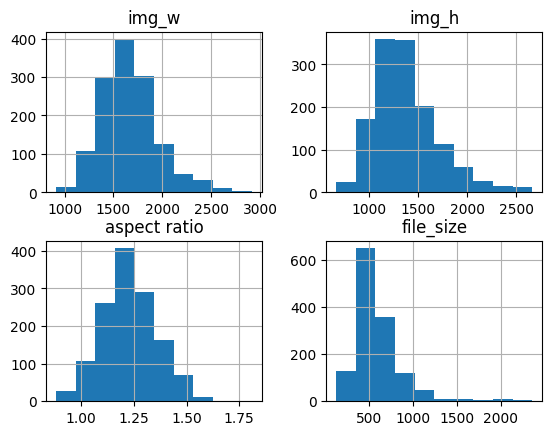

In [8]:
train_df_normal.hist()

array([[<Axes: title={'center': 'img_w'}>,
        <Axes: title={'center': 'img_h'}>],
       [<Axes: title={'center': 'aspect ratio'}>,
        <Axes: title={'center': 'file_size'}>]], dtype=object)

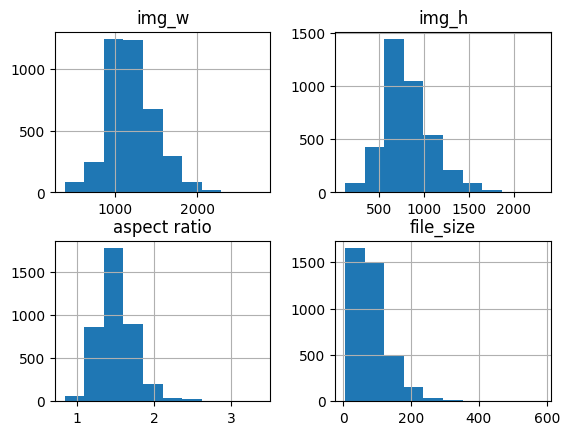

In [9]:
train_df_pneumonia.hist()

## Calculate memory for raw data matrix :

**train set : normal**

- Estimate image dimonsions: 
    - total # of images :  1341
    - average image size : 500Kb
    - average image width : 1667.734526
    - average image height : 1381.431022
    - average aspect ratio : 1.513756

**train set : pneumonia**

- Estimate image dimonsions: 
    - total # of images :  3875
    - average image size : 500Kb
    - average image width : 1200.4
    - average image height : 825.026839
    - average aspect ratio : 1.513756

loading images in grayscale and resizing 96X64 to maintain the aspect ratio

**function for image data preprocessing**

In [10]:
def image_preprocess(df:pd.DataFrame,address_feature:str,dx:int,dy:int)->np.ndarray:
    """ 
    - Reads in images and converts in to gray scale.
        re-size the image to (dx,dy), flattens the image, stores into a list
    - args : 
        df(pd Dataframe), 
        address_feature : column name containng image address
        dx : new image width
        dy : new image height
    - Returns : np.ndarray of shape (N, dx x dy)
    """
    image_data = []
    for i,p in enumerate(df[address_feature].tolist()):
        try:
            img_gray = cv2.imread(p,cv2.IMREAD_GRAYSCALE)
            if img_gray is None:
                print(f"Could not read{p}")
                continue
            resized_image = cv2.resize(img_gray, (dx,dy), interpolation=cv2.INTER_AREA)
            img_flatten = resized_image.flatten() # converting image to numpy array 
            image_data.append(img_flatten)
        except Exception as e:
            print(f"Error processinf{p}:{e}")
    return np.asarray(image_data, dtype=np.float32)

**Feature matrix**

In [11]:
X_train_normal = image_preprocess(train_df_normal,'file_path',96,64) # previously (w,h)=(96,64)

In [12]:
X_train_normal[1]

array([20., 31., 37., ...,  0.,  0.,  0.], shape=(6144,), dtype=float32)

In [13]:
X_train_pneumonia = image_preprocess(train_df_pneumonia,'file_path',96,64)
X_train = np.vstack([X_train_normal,X_train_pneumonia])

**Example images**

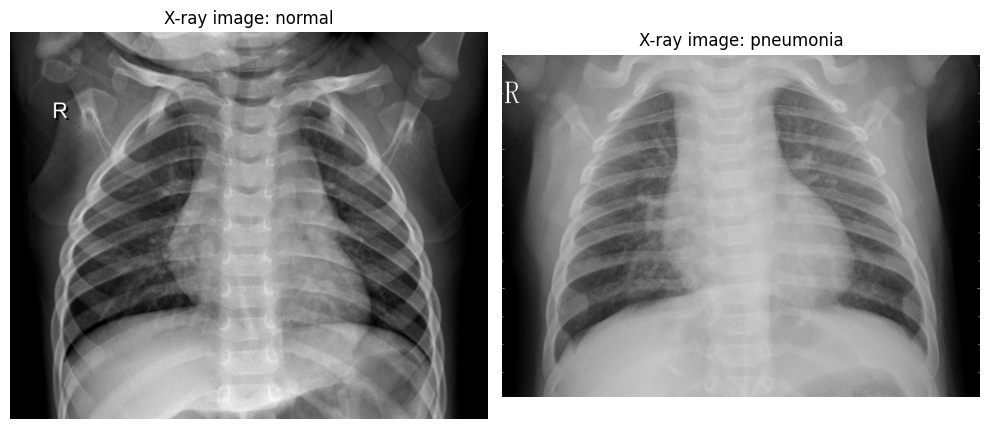

In [14]:
normal_image = Image.open(train_df_normal['file_path'][1])
pneumonia_image = Image.open(train_df_pneumonia['file_path'][1])
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.imshow(normal_image,cmap='gray')
plt.title("X-ray image: normal")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(pneumonia_image,cmap='gray')
plt.title("X-ray image: pneumonia")
plt.axis("off")
plt.tight_layout()
plt.show()

**Create label matrix**

In [15]:
y_train = np.array(['normal']*len(X_train_normal)+['pneumonia']*len(X_train_pneumonia))

In [16]:
len(X_train), len(y_train)

(5216, 5216)

**Create test data matrix**

In [17]:
# convert in to np array 
X_test_normal = image_preprocess(test_df_normal,'file_path',96,64)
X_test_pneumonia = image_preprocess(test_df_pneumonia,'file_path',96,64)

X_test = np.vstack([X_test_normal,X_test_pneumonia])
y_test = np.array(['normal']*len(X_test_normal)+["pneumonia"]*len(X_test_pneumonia))

len(X_test),len(y_test)

(624, 624)

## Apply PCA 

**Compute optimal number of Components**

*Standardize the datasets*

In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.fit_transform(X_test)

**function for finding optimal numbers of components**

In [19]:

def optimal_components_scree(X, threshold=0.95):
    """
    Determines optimal components using scree plot and cumulative variance.
    - args : 
        feature vector, threshold
    - output : generates two plots scree and elbow 
              vlaues ptimal_components, explained_variance, cumulative_variance
    """
    X_centered = X - X.mean(axis=0)
    U, s, Vh = np.linalg.svd(X_centered, full_matrices=False)
    # Calculate explained variance
    explained_variance = (s ** 2) / np.sum(s ** 2)
    cumulative_variance = np.cumsum(explained_variance)
    
    # Find optimal components
    optimal_components = np.argmax(cumulative_variance >= threshold) + 1
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(s) + 1), explained_variance, 'bo-')
    plt.xlabel('Principal Components')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Scree Plot')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(s) + 1), cumulative_variance, 'ro-')
    plt.axhline(y=threshold, color='g', linestyle='--', label=f'{threshold*100}% threshold')
    plt.axvline(x=optimal_components, color='r', linestyle='--', label=f'Optimal: {optimal_components}')
    plt.xlabel('Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Cumulative Variance')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    return optimal_components, explained_variance, cumulative_variance




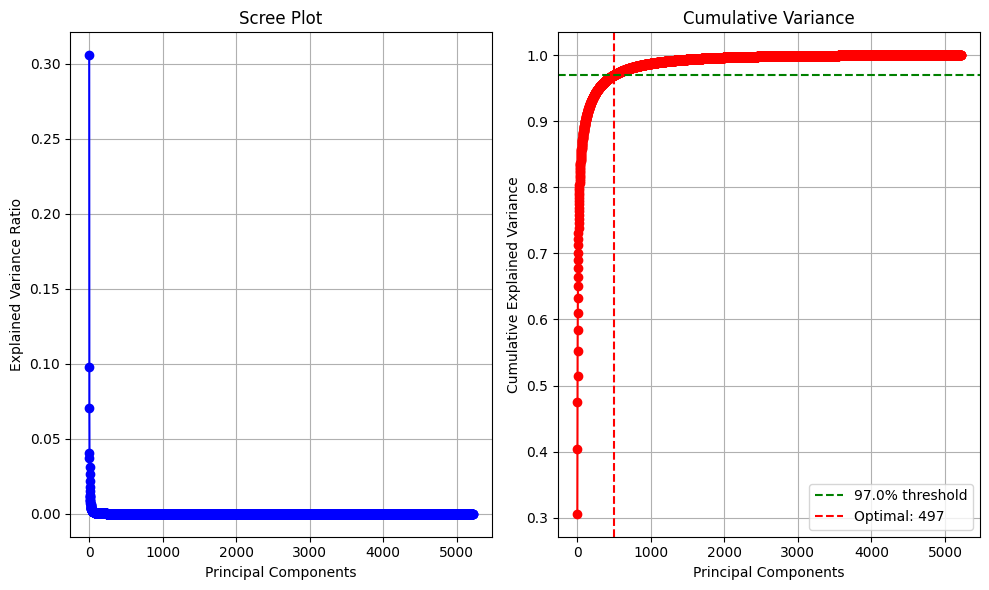

Optimal number of components: 497
Explained variance with 497 components: 97.005%


In [20]:

optimal_n, ev, cv = optimal_components_scree(X_train_scaled, threshold=0.97)
print(f"Optimal number of components: {optimal_n}")
print(f"Explained variance with {optimal_n} components: {cv[optimal_n-1]:.3%}")

## Insights

1. Massive dimensionality reduction: 6,144 → 497 features (92% reduction)

2. Information preservation: 97% variance retained

3. Computational efficiency: SVM will train much faster

4. Methodology: Used scree plot + cumulative variance for component selection

**PCA with optimal number of components**

In [21]:
optimal_pca = PCA(n_components = optimal_n)
X_train_pca = optimal_pca.fit_transform(X_train_scaled) # fit and transform, returns numpy array
X_test_scaled = scaler.transform(X_test)# returns numpy array
X_test_pca = optimal_pca.transform(X_test_scaled) # transform only, not fit! 

**Linear SVM**

In [22]:
from sklearn.metrics import accuracy_score, classification_report

# Linear SVM

lin_svm = LinearSVC(random_state=42,max_iter=10000)
lin_svm.fit(X_train_pca,y_train)

,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,1.0
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,verbose,0
,random_state,42


**prediction**

In [23]:
y_pred = lin_svm.predict(X_test_pca)


In [24]:
accuracy = accuracy_score(y_test,y_pred)

print(f"accuracy score : {accuracy:.3f}")

accuracy score : 0.755


**Accuracy 75.5%. Better than random: 50% would be random guessing (2 classes)**

**Baseline score: 0.755**

In [25]:
from sklearn.metrics import confusion_matrix

print("Classification Report:\n")
print(classification_report(y_test,y_pred))

Classification Report:

              precision    recall  f1-score   support

      normal       0.91      0.38      0.54       234
   pneumonia       0.73      0.98      0.83       390

    accuracy                           0.75       624
   macro avg       0.82      0.68      0.69       624
weighted avg       0.79      0.75      0.72       624



In [26]:
print("Confusion Matrix:\n")
print(confusion_matrix(y_test,y_pred))

Confusion Matrix:

[[ 90 144]
 [  9 381]]


**Addressing class imabalance:**

In [27]:
# Check this:
print("Training distribution:")
print(f"Pneumonia: {(y_train == 'pneumonia').sum()}")
print(f"Normal: {(y_train == 'normal').sum()}")

Training distribution:
Pneumonia: 3875
Normal: 1341


In [28]:
lin_svm_balanced = LinearSVC(class_weight='balanced', random_state=42,max_iter=10000)

In [29]:
lin_svm_balanced.fit(X_train_pca,y_train)

,penalty,'l2'
,loss,'squared_hinge'
,dual,'auto'
,tol,0.0001
,C,1.0
,multi_class,'ovr'
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,verbose,0
,random_state,42


In [30]:
y_pred_balanced = lin_svm_balanced.predict(X_test_pca)

In [31]:
accuracy_balanced = accuracy_score(y_test,y_pred_balanced)
print(f"accuracy score: {accuracy_balanced:.3f}")

accuracy score: 0.756


In [32]:
print("Classification report[balanced class weigth]:\n")
print(classification_report(y_test,y_pred_balanced))

Classification report[balanced class weigth]:

              precision    recall  f1-score   support

      normal       0.91      0.39      0.54       234
   pneumonia       0.73      0.98      0.83       390

    accuracy                           0.76       624
   macro avg       0.82      0.68      0.69       624
weighted avg       0.80      0.76      0.73       624



In [33]:
print("Confusion matrix[balanced class weight]:\n")
print(confusion_matrix(y_test,y_pred_balanced))

Confusion matrix[balanced class weight]:

[[ 91 143]
 [  9 381]]


**Class difference check**

In [34]:
# Check if the models are actually different
print("Default model coefficients shape:", lin_svm.coef_.shape)
print("Balanced model coefficients shape:", lin_svm_balanced.coef_.shape)

# Compare a few coefficients
print("First 5 coefficients - Default:", lin_svm.coef_[0][:5])
print("First 5 coefficients - Balanced:", lin_svm_balanced.coef_[0][:5])

Default model coefficients shape: (1, 497)
Balanced model coefficients shape: (1, 497)
First 5 coefficients - Default: [-0.00504605  0.08511323 -0.17030508 -0.02132538  0.06784957]
First 5 coefficients - Balanced: [-0.00513979  0.08487143 -0.16907502 -0.02113128  0.06709207]


## RBF SVM on PCA Features 

In [35]:
svm_rbf = SVC(kernel='rbf',probability=True,random_state=42)
svm_rbf.fit(X_train_pca,y_train)
y_pred_rbf = svm_rbf.predict(X_test_pca)
y_pred_proba = svm_rbf.predict_proba(X_test_pca)
print("Classification report:\n")
print(classification_report(y_test,y_pred_rbf))

Classification report:

              precision    recall  f1-score   support

      normal       0.95      0.42      0.59       234
   pneumonia       0.74      0.99      0.85       390

    accuracy                           0.78       624
   macro avg       0.85      0.71      0.72       624
weighted avg       0.82      0.78      0.75       624



In [36]:
from sklearn.metrics import roc_auc_score

print("Accuracy score:",accuracy_score(y_pred,y_pred_rbf))
print("confusion matrix:\n")
print(confusion_matrix(y_test,y_pred_rbf))
print("ROC_auc_score:", roc_auc_score(y_test,y_pred_proba[:,1]))

Accuracy score: 0.8766025641025641
confusion matrix:

[[ 99 135]
 [  5 385]]
ROC_auc_score: 0.9180911680911681


## ROC Curve + Precision-Recall Curve(SVM RBF model)

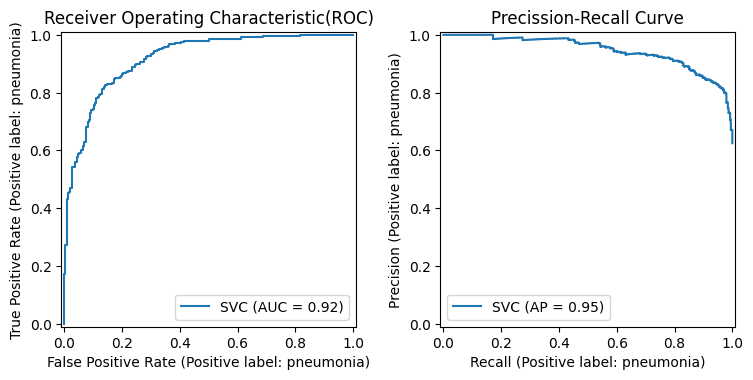

In [65]:
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay

# create and show the ROC curve plot

fig, (ax_roc,ax_pr) = plt.subplots(1,2,figsize=(8,6))
fig.tight_layout(pad=3.0)
roc_display = RocCurveDisplay.from_estimator(svm_rbf, X_test_pca, y_test, name='SVC', ax=ax_roc)
pr_display = PrecisionRecallDisplay.from_estimator(
    svm_rbf, X_test_pca, y_test, name='SVC', ax=ax_pr
)
ax_roc.set_title("Receiver Operating Characteristic(ROC)")
ax_roc.set_aspect('equal',adjustable='box')
ax_pr.set_title("Precission-Recall Curve")
ax_pr.set_aspect('equal', adjustable='box')
plt.show()


## Methodology Evolution:

1. PCA + Linear SVM (75.5%) - Established baseline
2. PCA + RBF SVM (87.6%) - Revealed non-linear patterns  
    - ROC_auc_score : 0.918
3. CNN (X%) - Deep feature learning for final performance

# CNN (Convolutional Neural Network)

I will create and implement CNN for this same problem to see if this imporoves the accuracy of the model.

In [38]:
# default libraries for PyTorch
import torch 
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

**Setup and Data loading**

In [42]:

# Dataset class 
class ChestXRayDataset(Dataset):
    def __init__(self,normal_dir,pneumonia_dir,transform=None, img_size=(96,64)):
        """ 
        Args: 
        - normal_dir(str): Directory with normal chest x-ray images
        - pneumonia_dir(str): Dierctory with normal chest x-ray images
        - transform (callable, optional): Optional transform to be applied on a sample
        - img_size(tuple) : Target image size (width, height) 
        Returns:
         - image and labels
        """
        self.transform = transform
        self.img_size = img_size

        # collect file path and labels
        self.file_paths = []
        self.labels = []

        # normal images (label 0)
        if os.path.exists(normal_dir):
            for filename in os.listdir(normal_dir):
                if (not filename.startswith('.')) and filename.lower().endswith(('.png','.jpeg','.jpg')):
                    self.file_paths.append(os.path.join(normal_dir, filename))
                    self.labels.append(0) # 0 for normal
        # pneumonia images (label 1)
        if os.path.exists(pneumonia_dir):
            for filename in os.listdir(pneumonia_dir):
                if (not filename.startswith('.')) and filename.lower().endswith(('.png','.jpg','.jpeg')):
                    self.file_paths.append(os.path.join(pneumonia_dir,filename))
                    self.labels.append(1) # 1 for pneumonia
        print(f"Loaded {len(self.file_paths)} images: {sum(self.labels)} pneumonia, {len(self.labels)-sum(self.labels)} normal")

    def __len__(self):
        return len(self.file_paths)
        
    def __getitem__(self,idx):
        img_path = self.file_paths[idx]
        label = self.labels[idx]
        # load images 
        image = Image.open(img_path).convert('L') # convert to grayscale
        # Apply transforms
        if self.transform: 
            image = self.transform(image)
        return image, label


**Calculate the datasets statistics**

In [43]:
def compute_mean_std(dataset):
    """Compute mean and standard deviation of dataset for normalization"""
    loader = DataLoader(dataset,batch_size=64, shuffle=True, num_workers=0)
    mean = 0.0
    std = 0.0 
    nb_samples = 0

    for data, _ in loader:
        batch_samples = data.size(0)
        data = data.view(batch_samples,data.size(1),-1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std  /= nb_samples

    return mean, std 


First pass to calculate statisitcs with basic transform

In [44]:
# basic transforms 
basic_transform = transforms.Compose(
    [transforms.Resize((64,96)), # PIL uses img dimensions as (height, width)
     transforms.ToTensor()
     
     ]
)

# create temporary dataset for Statistical Calculation

temp_dataset = ChestXRayDataset(
    normal_dir = path_train_normal,
    pneumonia_dir= path_train_pneumonia,
    transform= basic_transform
)

data_mean, data_std = compute_mean_std(temp_dataset)
print(f"Dataset - Mean:{data_mean.item():.4f}, Std:{data_std.item():.4f}")

Loaded 5216 images: 3875 pneumonia, 1341 normal
Dataset - Mean:0.4823, Std:0.2192


A simple and pre-trained network(Resnet-18) were experimented using this computed mean and Std from this current dataset. The resultant accuracy and ROC_AOC was not promising compared to the results achieved by PCA->SVM. 
In the next steps, I am resizing the training images to 224 X 224 and using mean std that is commonly used in the pre-trained Resnet-18.

**get device type**

In [45]:
def get_device():
    """ Returns device type based on the computing system """

    if torch.cuda.is_available(): # cuda , GPU
        device = torch.device("cuda:0")
    elif torch.backends.mps.is_available(): # apple silicon
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    return device

**Normalization with computed mean and standard deviation**

In [46]:

#ImageNet Mean and Std for 3-channel input
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
train_transform = transforms.Compose([
    transforms.Resize((224,224)), # (height,width)
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    # data augmentation block
    transforms.RandomHorizontalFlip(p=0.5), # Data augmentation
    transforms.RandomRotation(5), # Data augmentation
    # geometric transforms
    transforms.RandomAffine(degrees=0.01, translate=(0.1,0.1),shear=1.5),
    # Color transforms
    transforms.ColorJitter(brightness=0.2,contrast=0.2),
    transforms.Normalize(mean = IMAGENET_MEAN ,std= IMAGENET_STD)
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)) ,
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN,std=IMAGENET_STD)
])

val_transform = transforms.Compose([
    transforms.Resize((224,224)) ,
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN,std=IMAGENET_STD)

])

**Dataloader with Train/Val split**

In [47]:
from torch.utils.data import random_split

# create full train dataset
train_dataset = ChestXRayDataset(
    normal_dir = path_train_normal,
    pneumonia_dir = path_train_pneumonia,
    transform=train_transform,
) 

# split into train and validation 

#train_size = int(0.9*len(full_train_dataset))
#val_size = len(full_train_dataset) - train_size
#train_dataset, val_dataset = random_split(full_train_dataset,[train_size,val_size])

# create test dataset
test_dataset = ChestXRayDataset(
    normal_dir = path_test_normal,
    pneumonia_dir = path_test_pneumonia,
    transform = test_transform,
)
val_dataset = ChestXRayDataset(
    normal_dir = path_val_normal,
    pneumonia_dir = path_val_pneumonia,
    transform= val_transform,
)

# create dataloader 
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset,batch_size=32, shuffle=False, num_workers=0)

print(F"Train:{len(train_dataset)}, Val:{len(val_dataset)}, Test:{len(test_dataset)}")


Loaded 5216 images: 3875 pneumonia, 1341 normal
Loaded 624 images: 390 pneumonia, 234 normal
Loaded 16 images: 8 pneumonia, 8 normal
Train:5216, Val:16, Test:624


**Class weight calculation**

$weight_{i} = \frac{Total Samples}{Number \ of \ classes \times Smaples \ in \ class_{i}}$

- $N_{Total}$ : Total number of traiing samples.
- $N_{class 0}$(Normal): Samples in normal class.
- $N_{class 1}$(disease): Samples in the disease class. 


**train data weight calculation**

In [48]:
class_weight_pneumonia = 5216 / (2 * 3875)
class_weight_normal = 5216 / (2* 1341)

print(f"Pneumonic class weight:{class_weight_pneumonia:.3f}, Normal class weight:{class_weight_normal:.3f}")

Pneumonic class weight:0.673, Normal class weight:1.945


**model train function**

In [49]:
def train_model(model, train_loader, criterion, optimizer, epochs=5, 
                 schedule=True, scheduler_type='step', print_lr=True):
    
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available(): # apple silicon
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    print(f"Using device:{device}")
    model.to(device)
    model.train()
    
    # Different scheduler options
    if schedule:
        if scheduler_type == 'step':
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
        elif scheduler_type == 'cosine':
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
        elif scheduler_type == 'plateau':
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.5)
    else:
        scheduler = None
    
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (data, targets) in enumerate(train_loader):
            data = data.to(device)
            targets = targets.to(device)
            outputs = model(data)
            loss = criterion(outputs, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        avg_loss = running_loss / len(train_loader)
        
        # Handle different scheduler types
        if scheduler:
            if scheduler_type == 'plateau':
                scheduler.step(avg_loss)  # ReduceLROnPlateau needs the metric
            else:
                scheduler.step()          # Others step after each epoch
        
        # Print results
        if print_lr and schedule:
            current_lr = optimizer.param_groups[0]['lr']
            print(f'Epoch {epoch+1}/{epochs}, loss: {avg_loss:.4f}, lr: {current_lr:.6f}')
        else:
            print(f'Epoch {epoch+1}/{epochs}, loss: {avg_loss:.4f}')
    
    return avg_loss

**model evaluate function**


In [50]:
# evaluation function

def eval_model(model,data_loader, criterion=None):
    """  
    Evaluates CNN model using give model and test dataset.
    Args : 
    - model(nn.Module) : model to evalute.
    - test_loader(DataLoader) : test dataset loader
    - criterion(nn.Module, optional): Calculates loss
    - device : CPU or GPU device based on the availablility
    Returns : 
    - Dict : A dictionary containing evaluation metrics(e.g., accuracy, loss) 
    """
   
    # asign device
    if torch.cuda.is_available(): # cuda , GPU
        device = torch.device("cuda")
    elif torch.backends.mps.is_available(): # apple silicon
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    total_loss = 0.0
    all_preds = []
    all_labels = []
    model.to(device)
    model.eval()
    with torch.no_grad(): # disabled gradient calculation
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            if criterion:
                loss = criterion(outputs,labels)
                total_loss += loss.item() * inputs.size(0)

            _ , predicted = torch.max(outputs.data,1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(data_loader.dataset) if criterion else None
    accuracy = accuracy_score(all_labels,all_preds)
    # Example of other metrics (can be added as needed)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    # f1 = f1_score(all_labels, all_preds, average='weighted')
    metrics = {
        "accuracy" : accuracy,
        "precision" : precision,
        "recall"    : recall

    }
    if avg_loss is not None: 
        metrics["loss"] = avg_loss
    print(f"accuracy:{100*accuracy:.4f}%")
    return metrics 
    

**implement CNN**

In [51]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN,self).__init__()
        self.conv_layers = nn.Sequential(
            # first conv layer 
            nn.Conv2d(1,32,kernel_size=3,padding=1), # W_out,H_out = 96,64
            nn.ReLU(),
            nn.MaxPool2d(2), # W_out, H_out = 48, 32
            # second conv layer 
            nn.Conv2d(32,64,kernel_size=3,padding=1), # W_out,H_out = 48,32
            nn.ReLU(),
            nn.MaxPool2d(2), # W_out, H_out = 24,16

            # third Conv layer
            nn.Conv2d(64,128,kernel_size=3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2), # W_out,H_out = 12,8
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # first FC layer 
            nn.Linear(128*12*8, 256),
            nn.Dropout(0.5),
            # final fc layer
            nn.Linear(256,2) # two classes : normal, pneumonia
        )
    def forward(self,x):
        x = self.conv_layers(x)
        x = self.classifier(x)
        return x 
    
# initialize model

simpleModel = SimpleCNN()

**define criterion, optimizer**

In [52]:
# criterion 
criterion = nn.CrossEntropyLoss()
#optimizer 
optimizer = optim.Adam(simpleModel.parameters(), lr = 0.001)

**train the model**

In [18]:
eval_model?

Signature: eval_model(model, data_loader, criterion=None)
Docstring:
Evaluates CNN model using give model and test dataset.
Args : 
- model(nn.Module) : model to evalute.
- test_loader(DataLoader) : test dataset loader
- criterion(nn.Module, optional): Calculates loss
- device : CPU or GPU device based on the availablility
Returns : 
- Dict : A dictionary containing evaluation metrics(e.g., accuracy, loss) 
File:      /var/folders/hf/79z0gw250v93whn49815s_gm0000gn/T/ipykernel_2644/4221049290.py
Type:      function

**Train model**

In [16]:
train_model(simpleModel,train_loader,criterion,optimizer,epochs=25,schedule=True,scheduler_type='plateau')

Using device:mps
Epoch 1/25, loss: 0.3685, lr: 0.001000
Epoch 2/25, loss: 0.1843, lr: 0.001000
Epoch 3/25, loss: 0.1649, lr: 0.001000
Epoch 4/25, loss: 0.1332, lr: 0.001000
Epoch 5/25, loss: 0.1174, lr: 0.001000
Epoch 6/25, loss: 0.1104, lr: 0.001000
Epoch 7/25, loss: 0.1054, lr: 0.001000
Epoch 8/25, loss: 0.1103, lr: 0.001000
Epoch 9/25, loss: 0.1016, lr: 0.001000
Epoch 10/25, loss: 0.0955, lr: 0.001000
Epoch 11/25, loss: 0.0960, lr: 0.001000
Epoch 12/25, loss: 0.0911, lr: 0.001000
Epoch 13/25, loss: 0.0945, lr: 0.001000
Epoch 14/25, loss: 0.0803, lr: 0.001000
Epoch 15/25, loss: 0.0919, lr: 0.001000
Epoch 16/25, loss: 0.0793, lr: 0.001000
Epoch 17/25, loss: 0.0813, lr: 0.001000
Epoch 18/25, loss: 0.0787, lr: 0.001000
Epoch 19/25, loss: 0.0777, lr: 0.001000
Epoch 20/25, loss: 0.0736, lr: 0.001000
Epoch 21/25, loss: 0.0708, lr: 0.001000
Epoch 22/25, loss: 0.0792, lr: 0.001000
Epoch 23/25, loss: 0.0638, lr: 0.001000
Epoch 24/25, loss: 0.0770, lr: 0.001000
Epoch 25/25, loss: 0.0690, lr: 0

0.06902850334386841

**Evaluate model**

In [17]:
eval_data = eval_model(simpleModel,data_loader=val_loader,criterion=criterion)

accuracy:96.1686%


In [18]:
print(eval_data)

{'accuracy': 0.9616858237547893, 'precision': 0.9625263782736752, 'recall': 0.9616858237547893, 'loss': 0.1193019577955035}


**Evaluation on held-out test set**

In [19]:
test_metrics = eval_model(simpleModel,data_loader=test_loader, criterion=criterion)
print(test_metrics)

accuracy:84.2949%
{'accuracy': 0.842948717948718, 'precision': 0.8639989779695663, 'recall': 0.842948717948718, 'loss': 0.5809237870733994}


**Apply ResNet**

I experimented with Resnet-18 for two different color spaces. 1. gray scale and 2. RGB. The X-ray images are gray scale originally and it was made sure while leading in the images are in gray scale. A Resnet-18 network with gray scale training image did not yiled a good accuracy compared to PCA-> SVM model. After converting the training images to 3 channels to align it with the Resnet-18 architecture the results was promising. 

In [16]:
import torchvision.models as models
class ResNetXRay(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        # Use pretrained ResNet (trained on ImageNet)
        self.backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        for param in self.backbone.parameters():
                param.requires_grad = False
        # Modify first conv layer for grayscale (1 channel vs 3)
        self.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)
        
        # Modify final layer for our 2 classes
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)
        for param in self.backbone.fc.parameters():
             param.requires_grad = True
    
    def forward(self, x):
        return self.backbone(x)

# Usage
resnet_model = ResNetXRay()

In [53]:
import torchvision.models as models
class ResNetXRay_RGB(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        # Use pretrained ResNet channel 3 (trained on ImageNet)
        self.backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        for param in self.backbone.parameters():
                param.requires_grad = False
        # Modify first conv layer for grayscale (1 channel vs 3)
        #self.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)
        
        # Modify final layer for2 classes
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(num_features, num_classes)
    
    def forward(self, x):
        return self.backbone(x)

# Usage
resnet_model_RGB = ResNetXRay_RGB()

**ImprovedSimpleCNN**

In [20]:
# Enhance your current model
class ImprovedSimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.BatchNorm2d(32),  # Add batch norm
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.1),   # Add spatial dropout
            
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.2),
            
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.3),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 12 * 8, 256),
            nn.BatchNorm1d(256),  # Add batch norm to linear
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 2)
        )
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.classifier(x)
        return x

improved_CNN = ImprovedSimpleCNN()

**Train model function with early stopping**

In [54]:

def train_model_early_stoping(model, train_loader, val_loader, criterion, optimizer, epochs=5, 
                 schedule=True, scheduler_type='step', print_lr=True):
    """   
    trains model with early stoping and scheduler .
    Args: 
    - model(nn.Module): CNN model.
    - train_loader(nn.Module): train data loader.
    - val_loader(nn.Module) : validation data loader 
    - critetion : nn.CrossEntropyLoss().
    - optimizer : PyTroch optim function.
    Returns: 
    list : A history list containing validation metrics
    """
    
    # 1. Determine the device only once for the entire process
    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available(): # apple silicon
        device = torch.device("mps")
    else:
        device = torch.device("cpu")
    print(f"Training and validating on device: {device}")
    
    # Move model to the selected device
    model.to(device)
    best_val_loss = float('inf')
    best_model_path = '/Users/imrankhan/AI_ML_Projects/Chest_Xray/best_model/xray_cnn_bestmodel.pth'
    patience = 5 
    epochs_no_improve = 0
    # ... (Scheduler setup remains mostly the same) ...
    if schedule:
        if scheduler_type == 'step':
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
        elif scheduler_type == 'cosine':
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
        elif scheduler_type == 'plateau':
            # Note: ReduceLROnPlateau is best used with validation metrics
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)
    else:
        scheduler = None
    
    history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}

    for epoch in range(epochs):
        # --- Training Phase ---
        model.train() # Set model to training mode
        running_loss = 0.0
        for batch_idx, (data, targets) in enumerate(train_loader):
            data = data.to(device)
            targets = targets.to(device)
            
            outputs = model(data)
            loss = criterion(outputs, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        
        avg_train_loss = running_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # --- Validation Phase ---
        # Call the evaluation function using the validation data loader
        # We pass the same criterion used for training to get validation loss
        val_metrics = eval_model(model, val_loader, criterion=criterion)
        avg_val_loss = val_metrics['loss']
        val_accuracy = val_metrics['accuracy']
        
        history['val_loss'].append(avg_val_loss)
        history['val_accuracy'].append(val_accuracy)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            # save the model
            torch.save(model.state_dict(),best_model_path)
            print(f"--> New best model saved at Epoch {epoch+1} with Val Loss: {best_val_loss:.4f}")
        else:
            epochs_no_improve += 1
            print(f"No improvement for {epochs_no_improve} epochs.")
            # Check if early stopping criteria met
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}!")
                break # Exit the training loop early

        # --- Scheduler Step (using validation metric if required) ---
        if scheduler:
            if scheduler_type == 'plateau':
                # Step the plateau scheduler based on the validation loss
                scheduler.step(avg_val_loss)  
            else:
                # Other schedulers step after the epoch finishes
                scheduler.step()          
        
        # --- Print Results ---
        if print_lr and schedule:
            current_lr = optimizer.param_groups[0]['lr']
            print(f'Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy*100:.2f}% | LR: {current_lr:.6f}')
        else:
            print(f'Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy*100:.2f}%')
    # Load the best model weights found during training before returning
    model.load_state_dict(torch.load(best_model_path))
    print("model updated with the lowest val loss")
    return history

In [17]:
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, resnet_model.parameters()), lr=0.001,weight_decay=1e-4)
#optimizer = optim.Adam(improved_CNN.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

In [18]:
train_model_early_stoping(resnet_model,train_loader,val_loader,criterion,optimizer,epochs=10,schedule=True,scheduler_type='plateau')

Training and validating on device: mps
accuracy:56.2500%
--> New best model saved at Epoch 1 with Val Loss: 1.3179
Epoch 1/10 | Train Loss: 0.4171 | Val Loss: 1.3179 | Val Acc: 56.25% | LR: 0.001000
accuracy:56.2500%
No improvement for 1 epochs.
Epoch 2/10 | Train Loss: 0.3218 | Val Loss: 1.8590 | Val Acc: 56.25% | LR: 0.001000
accuracy:62.5000%
--> New best model saved at Epoch 3 with Val Loss: 1.0250
Epoch 3/10 | Train Loss: 0.2833 | Val Loss: 1.0250 | Val Acc: 62.50% | LR: 0.001000
accuracy:75.0000%
No improvement for 1 epochs.
Epoch 4/10 | Train Loss: 0.2868 | Val Loss: 1.4449 | Val Acc: 75.00% | LR: 0.001000
accuracy:56.2500%
No improvement for 2 epochs.
Epoch 5/10 | Train Loss: 0.2714 | Val Loss: 1.6943 | Val Acc: 56.25% | LR: 0.001000
accuracy:68.7500%
--> New best model saved at Epoch 6 with Val Loss: 0.7708
Epoch 6/10 | Train Loss: 0.2598 | Val Loss: 0.7708 | Val Acc: 68.75% | LR: 0.001000
accuracy:62.5000%
No improvement for 1 epochs.
Epoch 7/10 | Train Loss: 0.2433 | Val Los

{'train_loss': [0.41706088267586716,
  0.32179150341844265,
  0.2832619388776323,
  0.2867999205285786,
  0.27137315405841256,
  0.2597592748655863,
  0.24327262609831393,
  0.23335197119990742,
  0.2298304570004618,
  0.22526304716347184],
 'val_loss': [1.3178684711456299,
  1.859031081199646,
  1.0250056982040405,
  1.444948673248291,
  1.6942907571792603,
  0.7708330154418945,
  1.4635666608810425,
  0.9126842021942139,
  0.783099889755249,
  1.2185921669006348],
 'val_accuracy': [0.5625,
  0.5625,
  0.625,
  0.75,
  0.5625,
  0.6875,
  0.625,
  0.6875,
  0.75,
  0.6875]}

In [19]:
test_metrics = eval_model(resnet_model,data_loader=test_loader, criterion=criterion)
print(test_metrics)

accuracy:83.4936%
{'accuracy': 0.8349358974358975, 'precision': 0.8365848211554229, 'recall': 0.8349358974358975, 'loss': 0.45247756250393695}


**Trying the ImprovedSimpleCNN**

In [21]:
optimizer = optim.Adam(improved_CNN.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

In [22]:
train_model_early_stoping(improved_CNN,train_loader,val_loader,criterion,optimizer,epochs=10,schedule=True,scheduler_type='plateau')

Training and validating on device: mps
accuracy:87.5000%
--> New best model saved at Epoch 1 with Val Loss: 0.3439
Epoch 1/10 | Train Loss: 0.3225 | Val Loss: 0.3439 | Val Acc: 87.50% | LR: 0.001000
accuracy:75.0000%
No improvement for 1 epochs.
Epoch 2/10 | Train Loss: 0.2223 | Val Loss: 0.5508 | Val Acc: 75.00% | LR: 0.001000
accuracy:75.0000%
No improvement for 2 epochs.
Epoch 3/10 | Train Loss: 0.1786 | Val Loss: 0.5384 | Val Acc: 75.00% | LR: 0.001000
accuracy:81.2500%
--> New best model saved at Epoch 4 with Val Loss: 0.3258
Epoch 4/10 | Train Loss: 0.1551 | Val Loss: 0.3258 | Val Acc: 81.25% | LR: 0.001000
accuracy:81.2500%
--> New best model saved at Epoch 5 with Val Loss: 0.2938
Epoch 5/10 | Train Loss: 0.1613 | Val Loss: 0.2938 | Val Acc: 81.25% | LR: 0.001000
accuracy:68.7500%
No improvement for 1 epochs.
Epoch 6/10 | Train Loss: 0.1422 | Val Loss: 0.4431 | Val Acc: 68.75% | LR: 0.001000
accuracy:93.7500%
No improvement for 2 epochs.
Epoch 7/10 | Train Loss: 0.1383 | Val Los

{'train_loss': [0.3224703034648866,
  0.22234017840740872,
  0.17860366534327438,
  0.1550817802731245,
  0.16126302655991967,
  0.14224522657966687,
  0.1383391781338702,
  0.13581791387562372,
  0.12980824968337648,
  0.12160047590504029],
 'val_loss': [0.34392809867858887,
  0.5508070588111877,
  0.5384353995323181,
  0.32580938935279846,
  0.2937595844268799,
  0.4430672526359558,
  0.3236847221851349,
  0.6232233047485352,
  0.6613888144493103,
  0.31312036514282227],
 'val_accuracy': [0.875,
  0.75,
  0.75,
  0.8125,
  0.8125,
  0.6875,
  0.9375,
  0.6875,
  0.6875,
  0.875]}

In [24]:
test_metrics_improvedCN = eval_model(improved_CNN,data_loader=test_loader, criterion=criterion)
print(test_metrics_improvedCN)

accuracy:79.8077%
{'accuracy': 0.7980769230769231, 'precision': 0.813767459528958, 'recall': 0.7980769230769231, 'loss': 0.531310650973748}


## Applying resnet RGB

In [55]:
class_weights = torch.tensor([class_weight_normal,class_weight_pneumonia],dtype=torch.float32)
device = get_device()
class_weights = class_weights.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
print(f"CrossEntropyLoss initialized with weights:{class_weights}")
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, resnet_model_RGB.parameters()), lr=0.001,weight_decay=1e-4)

CrossEntropyLoss initialized with weights:tensor([1.9448, 0.6730], device='mps:0')


In [56]:
train_model_early_stoping(resnet_model_RGB,train_loader,val_loader,criterion,optimizer,epochs=10,schedule=True,scheduler_type='plateau')

Training and validating on device: mps
accuracy:93.7500%
--> New best model saved at Epoch 1 with Val Loss: 0.2328
Epoch 1/10 | Train Loss: 0.3327 | Val Loss: 0.2328 | Val Acc: 93.75% | LR: 0.001000
accuracy:93.7500%
No improvement for 1 epochs.
Epoch 2/10 | Train Loss: 0.2301 | Val Loss: 0.2742 | Val Acc: 93.75% | LR: 0.001000
accuracy:93.7500%
--> New best model saved at Epoch 3 with Val Loss: 0.1355
Epoch 3/10 | Train Loss: 0.1954 | Val Loss: 0.1355 | Val Acc: 93.75% | LR: 0.001000
accuracy:93.7500%
No improvement for 1 epochs.
Epoch 4/10 | Train Loss: 0.2138 | Val Loss: 0.1952 | Val Acc: 93.75% | LR: 0.001000
accuracy:93.7500%
No improvement for 2 epochs.
Epoch 5/10 | Train Loss: 0.1839 | Val Loss: 0.1897 | Val Acc: 93.75% | LR: 0.001000
accuracy:100.0000%
No improvement for 3 epochs.
Epoch 6/10 | Train Loss: 0.1963 | Val Loss: 0.1553 | Val Acc: 100.00% | LR: 0.000500
accuracy:93.7500%
No improvement for 4 epochs.
Epoch 7/10 | Train Loss: 0.1662 | Val Loss: 0.1817 | Val Acc: 93.75%

{'train_loss': [0.3327082530395385,
  0.2300990999567728,
  0.19540468169136282,
  0.21381258722280433,
  0.18391533065701554,
  0.1962781922628909,
  0.16615455426230022,
  0.17668792527694643],
 'val_loss': [0.23276863992214203,
  0.27422231435775757,
  0.13549372553825378,
  0.19524215161800385,
  0.18972399830818176,
  0.15532444417476654,
  0.18167687952518463,
  0.26339393854141235],
 'val_accuracy': [0.9375, 0.9375, 0.9375, 0.9375, 0.9375, 1.0, 0.9375, 0.875]}

In [57]:
test_metrics_RGB = eval_model(resnet_model_RGB,data_loader=test_loader, criterion=criterion)

accuracy:88.4615%


In [58]:
print(test_metrics_RGB)

{'accuracy': 0.8846153846153846, 'precision': 0.8917755282059898, 'recall': 0.8846153846153846, 'loss': 0.3073953302242817}


In [59]:

from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix

In [60]:
def validate_model(model, val_loader, device):
    model.eval()
    all_labels = []
    all_preds_scores = []  # For AUC (probabilities)
    all_preds_classes = [] # For F1-Score (hard predictions)
    
    with torch.no_grad():
        for data, labels in val_loader:
            data = data.to(device)
            # labels are needed on CPU for scikit-learn
            all_labels.extend(labels.cpu().numpy()) 

            outputs = model(data)
            
            # --- Get Probabilities (Scores) for AUC ---
            # We use softmax to get probabilities. AUC only needs the probability of the positive class (Pneumonia=1).
            probs = torch.softmax(outputs, dim=1)[:, 1]
            all_preds_scores.extend(probs.cpu().numpy())
            
            # --- Get Hard Predictions (Classes) for F1-Score ---
            # Finds the index of the max logit (your hard prediction: 0 or 1)
            _, predicted = torch.max(outputs.data, 1) 
            all_preds_classes.extend(predicted.cpu().numpy())

    # --- Convert lists to numpy arrays for scikit-learn ---
    all_labels = np.array(all_labels)
    all_preds_scores = np.array(all_preds_scores)
    all_preds_classes = np.array(all_preds_classes)
    
    # 3. Calculate and Print Metrics
    
    # Check if we have enough unique classes for AUC calculation
    if len(np.unique(all_labels)) < 2:
        print("Warning: Only one class present in validation set. Skipping AUC/F1-score.")
        return None
        
    # --- AUC-ROC (Model's ability to distinguish classes) ---
    auc = roc_auc_score(all_labels, all_preds_scores)
    
    # --- F1-Scores (Precision/Recall balance) ---
    # F1-weighted: Accounts for class imbalance (good overall measure)
    f1_weighted = f1_score(all_labels, all_preds_classes, average='weighted')
    # F1-binary: Specifically for the POSITIVE (Pneumonia=1) class
    f1_positive = f1_score(all_labels, all_preds_classes, average='binary') 

    # --- Confusion Matrix (Diagnostic Tool) ---
    cm = confusion_matrix(all_labels, all_preds_classes)

    print("\n" + "="*40)
    print(f"**VALIDATION METRICS**")
    print("="*40)
    print(f"AUC-ROC:            {auc:.4f} (Goal > 0.95)")
    print(f"F1-Score (Weighted):{f1_weighted:.4f}")
    print(f"F1-Score (Pneumonia): {f1_positive:.4f} (Goal > 0.85)")
    print("\nConfusion Matrix:")
    print("      Predicted Normal (0) | Predicted Pneumonia (1)")
    print(f"True Normal (0):    {cm[0, 0]} (TN)           | {cm[0, 1]} (FP)")
    print(f"True Pneu (1):      {cm[1, 0]} (FN)            | {cm[1, 1]} (TP)")
    print("="*40)
    
    return {'auc': auc, 'f1_weighted': f1_weighted, 'f1_pneumonia': f1_positive, 'cm': cm}

In [61]:
eval_model = validate_model(resnet_model_RGB, test_loader, device)


**VALIDATION METRICS**
AUC-ROC:            0.9518 (Goal > 0.95)
F1-Score (Weighted):0.8858
F1-Score (Pneumonia): 0.9037 (Goal > 0.85)

Confusion Matrix:
      Predicted Normal (0) | Predicted Pneumonia (1)
True Normal (0):    214 (TN)           | 20 (FP)
True Pneu (1):      52 (FN)            | 338 (TP)


**Load the saved state Dictionary**

In [62]:
device = get_device()
MODEL_PATH = '../best_model/xray_cnn_bestmodel.pth'
try: 
    state_dict = torch.load(MODEL_PATH,map_location=device)
    resnet_model_RGB.load_state_dict(state_dict)
    resnet_model_RGB.to(device)
    resnet_model_RGB.eval()
    print(f"Model loaded sucessfully from{MODEL_PATH} and set to evaluation mode.")
except Exception as e:
    print(e)


Model loaded sucessfully from../best_model/xray_cnn_bestmodel.pth and set to evaluation mode.


**Define Transforms and Grad-CAm Functions**

In [63]:
# Re-define image normalization constants
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
image_resize = (224, 224) 

# Re-define the validation transform 
val_transform = transforms.Compose([
    transforms.Resize(image_resize),
    transforms.Grayscale(num_output_channels=3), 
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD) 
])

# generate grad-cam 
def generate_grad_cam(model, input_tensor, target_class=1): 
    """  
    Generates a Grad-CAM heatmap for a single input image.
    
    Args:
    - model(nn.Module): trained model(e.g., ResnetXRay_RGB)
    - input_tensor (torch.tensor): The 4D input tensor (1,C,H,W).
    - target_class(int): The index of the class to visualize(e.g., 1 for Pneumonia)
    """
    model.eval()
    feature_maps = None
    gradients = None 
    # last convolution block(layer 4)
    target_layer = model.backbone.layer4
    
    def forward_hook(module, input, output):
        nonlocal feature_maps
        feature_maps = output
    def backward_hook(module, grad_in, grad_out):
        nonlocal gradients 
        gradients = grad_out[0]

    # registering hooks on target layer
    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_backward_hook(backward_hook)
    # gradient for backprop
    input_tensor.requires_grad_(True)
    # forward pass and target Score
    output = model(input_tensor)
    # zero all gradients 
    model.zero_grad()
    # zero tensor for all classes except class_1
    one_hot = torch.zeros_like(output)
    one_hot[0][target_class] = 1.0 # batch size 1
    # Backpropagate the one-hot score
    output.backward(gradient=one_hot,retain_graph=True)
    # Compute Grad-CAM
    # Global average pooling of the gradients (alpha_k)
    # gradients shape: (1, 512, H, W) -> weights shape: (1, 512, 1, 1)
    weights = torch.mean(gradients,dim=(2,3),keepdim=True)
    # Compute weighted feature map (L_Grad-CAM)
    cam = torch.sum(weights * feature_maps, dim=1)
    # RelU to keep only positive influence
    cam = F.relu(cam)
    # formating 
    forward_handle.remove()
    backward_handle.remove()
    # resize to original image size 
    H,W = input_tensor.shape[2:]
    cam = F.interpolate(cam.unsqueeze(0),size=(H,W),mode='bilinear',align_corners=False)
    # normalize the heatmap to 0-1 range 
    cam = cam.detach().squeeze().cpu().numpy()
    cam = (cam-cam.min())/ (cam.max()-cam.min()+1e-8)

    return cam 


**plot**

/Users/imrankhan/AI_ML_Projects/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
/var/folders/hf/79z0gw250v93whn49815s_gm0000gn/T/ipykernel_45360/1165808388.py:19: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  plt.figure(1,2,2)


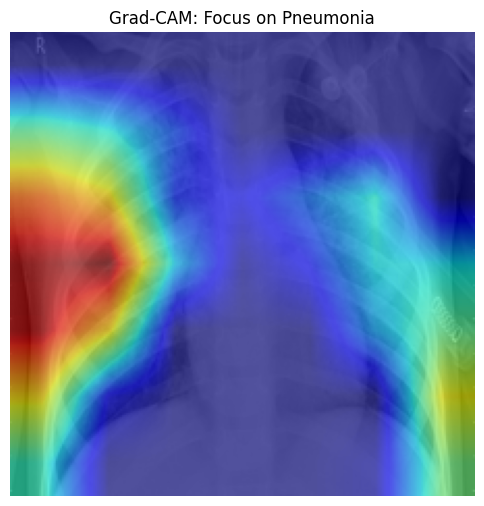

In [ ]:
# test pneumonia image 
pneumonia_image = '../Kaggle/chest_xray/chest_xray/test/PNEUMONIA/person3_virus_16.jpeg'
raw_image = Image.open(pneumonia_image).convert("RGB")

# input tensor
input_tensor = val_transform(raw_image).unsqueeze(0).to(device)
#heatmap 
heatmap = generate_grad_cam(resnet_model_RGB,input_tensor, target_class=1) 
# display results
resized_raw_image = raw_image.resize(image_resize)
original_img_np = np.array(resized_raw_image)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(original_img_np)
plt.title("Original Image")
plt.axis('off')

plt.figure(1,2,2)
plt.imshow(original_img_np, alpha=1.0)
#overlay the heat map
plt.imshow(heatmap, alpha=0.6, cmap='jet')
plt.title(f"Grad-CAM: Focus on Pneumonia")
plt.axis('off')
plt.tight_layout()
plt.show()

